# Deep Learning
## <font color="PURPLE">Author: </font> Mylonaki Angeliki
###  <font color="PURPLE"> Image Classification using Neural Networks </font>




In [343]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import  SGD,Adam,Adamax,Nadam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing

### Loading Train and Test data



In [344]:
def unpickle(file):
    with open(file, 'rb') as fo:
        d = cPickle.load(fo)
    return d["data"],d["labels"]

def loadLabelNames():
    with open("cifar-10-batches-py/batches.meta", 'rb') as fo:
        d = cPickle.load(fo)
    return d["label_names"]

temp=unpickle("cifar-10-batches-py/data_batch_1")
features=temp[0]
labels=temp[1]
for i in range(2,6):
    temp=unpickle("cifar-10-batches-py/data_batch_"+str(i))
    features=np.concatenate((features,temp[0]))
    labels=labels+temp[1]


X_test,Y_test=unpickle("cifar-10-batches-py/test_batch")
labelNames=loadLabelNames()

print "Input shape:", features.shape

Input shape: (50000, 3072)


### Plotting sample images from the dataset



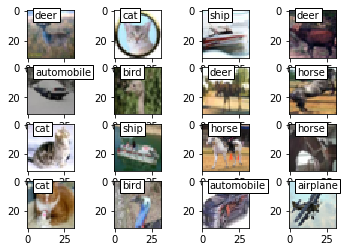

In [345]:
def calculate_position(ax1,ax2):
    ax2+=1
    if ax2==4:
        ax1+=1
        ax2=0
    if ax1==4:
        return -1,-1
    else:
        return ax1,ax2
    
    
def get_random_image(images,labels,label_names):
    maxIndex=features.shape[0]
    randomIndex=random.randint(0, maxIndex)
    
    im=images[randomIndex]
    label=labels[randomIndex]
    label_name=label_names[label]

    return im,label,label_name
    
def convert_to_rgb(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)
    
    return im_r,im_g,im_b
    
#plot image
def random_plot(images,labels,label_names):
    
    f, axarr=plt.subplots(4,4)
    d1=0
    d2=0
    
    for i in range(1,17):
        im,label,label_name=get_random_image(images,labels,label_names)
        
        #image "construction"
        im_r,im_g,im_b = convert_to_rgb(im)

        img = np.dstack((im_r, im_g, im_b))
        axarr[d1,d2].imshow(img)
        axarr[d1,d2].text(5, 5, label_name, bbox={'facecolor': 'white', 'pad': 2})
        
        d1,d2=calculate_position(d1,d2)
        if d1==-1:
            plt.show()
            return

random_plot(features,labels,labelNames)

### Normalizing Data and splitting into train/validation samples


In [346]:
num_classes = len(set(labels))
features = features.astype('float32')

X_test = X_test.astype('float32')

#Min Max Scaler
min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(features)
X_test = min_max_scaler.fit_transform(X_test)

labels = keras.utils.to_categorical(labels, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

X_train , X_val, Y_train, Y_val = train_test_split(features, labels, test_size=0.33, random_state=7)

batch_size =100
epochs = 40

### Defining useful functions



In [347]:
def plot_accuracy(history):
    print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


def create_model(optimizer):

    model = Sequential()

    #configuring layers
    model.add(Dense(512, activation='relu', input_shape=(3072,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))    
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    
    return model

def evaluate_model(model,bsize,ep):
    #callback functions
    stop_early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, mode='auto')
    history = model.fit(X_train, Y_train,
        batch_size=bsize,
        epochs=ep,
        validation_data=(X_val, Y_val),
        callbacks=[stop_early,], shuffle=True, verbose=0)


    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plot_accuracy(history)
    print('\n\n') 

### Try multiple Optimization Functions
In this step, having a basic neural network, we want to try several Optimization functions
to see who is behaving the best without any tuning of the parameters.

We are using Early Stopping

In [ ]:
optimizers=[SGD(),Adam(),Adamax(),Nadam()]
optimizer_names=["SGD","Adam","Adamax","Nadam"]

for optimizer,optimizer_name in zip(optimizers,optimizer_names):
    print"********************************************************"
    print "Optimizer:"+optimizer_name
    print"********************************************************"
    model=create_model(optimizer)
    evaluate_model(model,batch_size,epochs)   

********************************************************
Optimizer:SGD
********************************************************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_446 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dropout_176 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_447 (Dense)            (None, 512)               262656    
_________________________________________________________________
dropout_177 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_448 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_449 (Dense)            (None, 10)                5130      
Total params: 

### Selecting/Tuning  the Optimizer which produces the most accurate results
In our case it is SGD.
<br>
<br>
<b>We will now tune the parameters of the Optimizer</b>
<br>
<b>lr:</b>Learning rate
<br>
<b>momentum:</b> Parameter that accelerates SGD in the relevant direction
<br>
<b>decay:</b> Learning rate decay over each update
<br>
<b>nesterov:</b> boolean. Whether to apply Nesterov momentum.

In [ ]:
optimizer = SGD(lr=0.01,decay=0.0,momentum=0.9)
model=create_model(optimizer)
evaluate_model(model,batch_size,epochs)